In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import dataloader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import itertools

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
batch_size = 512
epochs = 20
learning_rate = 1e-4

cuda


In [ ]:
transform = torchvision.transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

total_train_size = len(train_dataset)

validation_split = 0.2
train_split = int(total_train_size * (1 - validation_split))
val_split = total_train_size - train_split

train_subset, val_subset = random_split(train_dataset, [train_split, val_split])

train_loader = torch.utils.data.DataLoader(
    train_subset, batch_size=batch_size, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_subset, batch_size=batch_size, shuffle=False
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
def custom_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

In [ ]:
input_dim = 28 * 28
output_dim = 10
model = MLP(input_dim=input_dim, output_dim=output_dim).to(device)

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.95, 0.9985))

In [ ]:
train_losses = []
val_losses = []

def train_model(model, loss_criterion, optimizer, train_loader, val_loader, epochs, train_losses, val_losses):
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images.view(images.size(0), -1))
            loss = loss_criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images.view(images.size(0), -1))
                loss = loss_criterion(output, labels)
                running_val_loss += loss.item()
        val_losses.append(running_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

train_model(model, loss_criterion, optimizer, train_loader, val_loader, epochs, train_losses, val_losses)


Epoch 1/20, Train Loss: 1.2917, Val Loss: 0.7224
Epoch 2/20, Train Loss: 0.6554, Val Loss: 0.4709
Epoch 3/20, Train Loss: 0.4632, Val Loss: 0.3523
Epoch 4/20, Train Loss: 0.3625, Val Loss: 0.2784
Epoch 5/20, Train Loss: 0.3000, Val Loss: 0.2317
Epoch 6/20, Train Loss: 0.2552, Val Loss: 0.1964
Epoch 7/20, Train Loss: 0.2232, Val Loss: 0.1691
Epoch 8/20, Train Loss: 0.1976, Val Loss: 0.1533
Epoch 9/20, Train Loss: 0.1763, Val Loss: 0.1408
Epoch 10/20, Train Loss: 0.1603, Val Loss: 0.1268
Epoch 11/20, Train Loss: 0.1470, Val Loss: 0.1175
Epoch 12/20, Train Loss: 0.1365, Val Loss: 0.1102
Epoch 13/20, Train Loss: 0.1285, Val Loss: 0.1076
Epoch 14/20, Train Loss: 0.1198, Val Loss: 0.0976
Epoch 15/20, Train Loss: 0.1156, Val Loss: 0.0951
Epoch 16/20, Train Loss: 0.1092, Val Loss: 0.0903
Epoch 17/20, Train Loss: 0.1011, Val Loss: 0.0894
Epoch 18/20, Train Loss: 0.1008, Val Loss: 0.0846
Epoch 19/20, Train Loss: 0.0965, Val Loss: 0.0837
Epoch 20/20, Train Loss: 0.0906, Val Loss: 0.0843


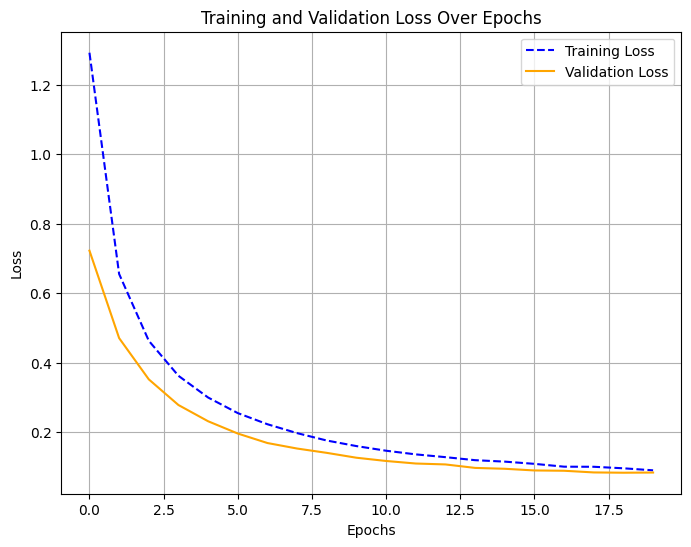

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss", color='blue', linestyle='--')
plt.plot(val_losses, label="Validation Loss", color='orange', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

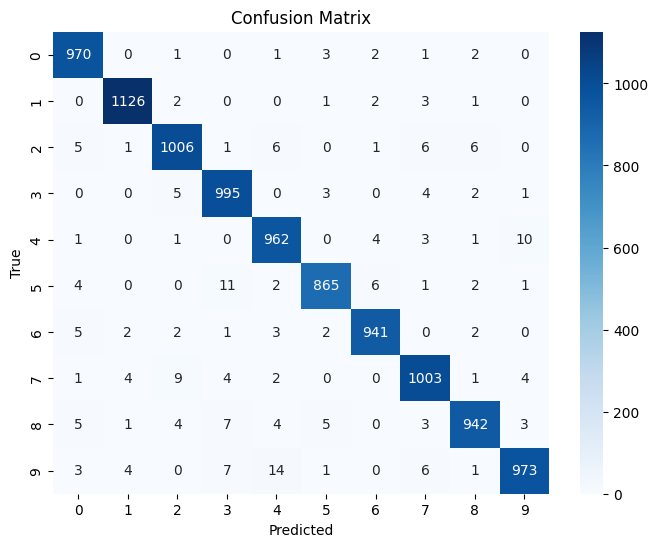

Test Loss: 0.0728
Precision: 0.9783
Recall: 0.9783
F1-score: 0.9783


In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images.view(images.size(0), -1))
            _, preds = torch.max(outputs, 1)
            loss = loss_criterion(outputs, labels)
            total_loss += loss.item()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return accuracy

test_accuracy = evaluate_model(model, test_loader, device)


In [ ]:
print(f"Model Accuracy: {test_accuracy}")

Model Accuracy: 97.83


In [ ]:
class MLPwithoutReg(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPwithoutReg, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model_without_reg = MLPwithoutReg(input_dim = 28 * 28, output_dim = 10).to(device)
model_without_reg.to(device)
model_without_reg.apply(custom_weights)

train_losses_without_reg = []
val_losses_without_reg = []
train_model(model_without_reg, loss_criterion, optimizer, train_loader, val_loader, epochs, train_losses_without_reg, val_losses_without_reg)

Epoch 1/20, Train Loss: 2.7543, Val Loss: 2.7616
Epoch 2/20, Train Loss: 2.7535, Val Loss: 2.7584
Epoch 3/20, Train Loss: 2.7535, Val Loss: 2.7614
Epoch 4/20, Train Loss: 2.7533, Val Loss: 2.7647
Epoch 5/20, Train Loss: 2.7529, Val Loss: 2.7636
Epoch 6/20, Train Loss: 2.7564, Val Loss: 2.7595
Epoch 7/20, Train Loss: 2.7541, Val Loss: 2.7619
Epoch 8/20, Train Loss: 2.7516, Val Loss: 2.7603
Epoch 9/20, Train Loss: 2.7521, Val Loss: 2.7630
Epoch 10/20, Train Loss: 2.7531, Val Loss: 2.7648
Epoch 11/20, Train Loss: 2.7555, Val Loss: 2.7651
Epoch 12/20, Train Loss: 2.7520, Val Loss: 2.7611
Epoch 13/20, Train Loss: 2.7521, Val Loss: 2.7649
Epoch 14/20, Train Loss: 2.7514, Val Loss: 2.7662
Epoch 15/20, Train Loss: 2.7569, Val Loss: 2.7630
Epoch 16/20, Train Loss: 2.7557, Val Loss: 2.7640
Epoch 17/20, Train Loss: 2.7513, Val Loss: 2.7624
Epoch 18/20, Train Loss: 2.7539, Val Loss: 2.7577
Epoch 19/20, Train Loss: 2.7535, Val Loss: 2.7588
Epoch 20/20, Train Loss: 2.7547, Val Loss: 2.7630


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


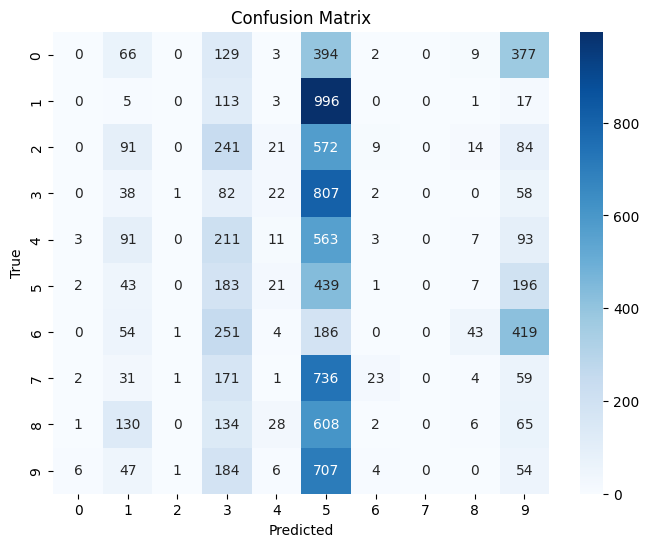

Test Loss: 2.7593
Precision: 0.0316
Recall: 0.0597
F1-score: 0.0257


In [ ]:
test_accuracy_without_reg = evaluate_model(model_without_reg, test_loader, device)

Model Accuracy With Regularizations: 97.83
Model Accuracy Without Regularizations: 5.97


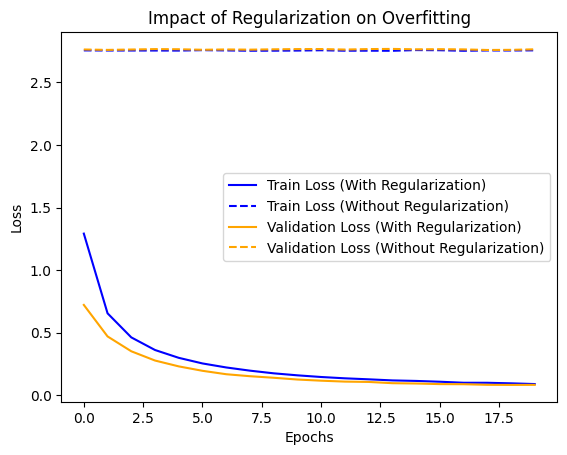

In [ ]:
print(f"Model Accuracy With Regularizations: {test_accuracy}")
print(f"Model Accuracy Without Regularizations: {test_accuracy_without_reg}")

plt.plot(train_losses, label="Train Loss (With Regularization)", color='blue')
plt.plot(train_losses_without_reg, label="Train Loss (Without Regularization)", linestyle='--', color='blue')
plt.plot(val_losses, label="Validation Loss (With Regularization)", color='orange')
plt.plot(val_losses_without_reg, label="Validation Loss (Without Regularization)", linestyle='--', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Impact of Regularization on Overfitting")
plt.legend()
plt.show()

In [ ]:
def train_model(model, loss_criterion, optimizer, train_loader, epochs, train_losses):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images.view(images.size(0), -1))
            loss = loss_criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images.view(images.size(0), -1))
            _, preds = torch.max(outputs, 1)
            loss = loss_criterion(outputs, labels)
            total_loss += loss.item()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return accuracy

In [ ]:
param_grid = {
    "learning_rate": [1e-4, 1e-3, 1e-2],
    "dropout_rate": [0.2, 0.4, 0.5],
}

best_accuracy = 0
best_params = {}

for lr, dr in itertools.product(param_grid["learning_rate"], param_grid["dropout_rate"]):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses=[]
    print(f"Training model with learning rate {lr} and dropout rate {dr}")
    train_model(model, loss_criterion, optimizer, train_loader, epochs, train_losses)
    accuracy = evaluate_model(model, test_loader, device)
    print(f"Accuracy with with learning rate {lr} and dropout rate {dr} = {accuracy}\n\n")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {"learning_rate": lr, "dropout_rate": dr}

print(f"Best Hyperparameters: {best_params}, Accuracy: {best_accuracy:.4f}")


Training model with learning rate 0.0001 and dropout rate 0.2
Precision: 0.9837
Recall: 0.9837
F1-score: 0.9837
Accuracy with with learning rate 0.0001 and dropout rate 0.2 = 98.37


Training model with learning rate 0.0001 and dropout rate 0.4
Precision: 0.9846
Recall: 0.9846
F1-score: 0.9846
Accuracy with with learning rate 0.0001 and dropout rate 0.4 = 98.46


Training model with learning rate 0.0001 and dropout rate 0.5
Precision: 0.9856
Recall: 0.9855
F1-score: 0.9855
Accuracy with with learning rate 0.0001 and dropout rate 0.5 = 98.55


Training model with learning rate 0.001 and dropout rate 0.2
Precision: 0.9839
Recall: 0.9839
F1-score: 0.9839
Accuracy with with learning rate 0.001 and dropout rate 0.2 = 98.39


Training model with learning rate 0.001 and dropout rate 0.4
Precision: 0.9862
Recall: 0.9862
F1-score: 0.9862
Accuracy with with learning rate 0.001 and dropout rate 0.4 = 98.62


Training model with learning rate 0.001 and dropout rate 0.5
Precision: 0.9857
Recall: 0.